In [1]:
import torch
import configparser
import control
from customDatasetMakers import state_to_dic
from dataSettings import get_denormalized_dic, get_normalized_dic
from customModels import IanRNN, HiroLRAN
from train_helpers import get_state_mask, get_sample_time_state_mask, masked_loss
import numpy as np
from scipy.sparse import csr_matrix
import customDatasetMakers
import matplotlib.pyplot as plt
import prediction_helpers
import osqp
import scipy as sp
from scipy import sparse
import pickle


In [5]:
A = torch.tensor([[0.1183, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0591, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0597, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1061, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1333]])

B = torch.tensor([[-0.4005,  0.0740, -0.0691,  0.1304,  0.2386, -0.3153],
        [ 0.3548, -0.2789, -0.1019, -0.2115,  0.1141, -0.0093],
        [-0.0883, -0.0893,  0.3150, -0.1771,  0.3832,  0.0962],
        [-0.1338,  0.0508,  0.3453,  0.0630, -0.1015, -0.0508],
        [ 0.1372,  0.1533, -0.0774,  0.0540,  0.1549, -0.3139]])
import train_helpers
print(train_helpers.get_controllability_A_B(torch.tensor(A), torch.tensor(B)))

tensor(0.1755)


/tmp/ipykernel_442963/1934865539.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(train_helpers.get_controllability_A_B(torch.tensor(A), torch.tensor(B)))


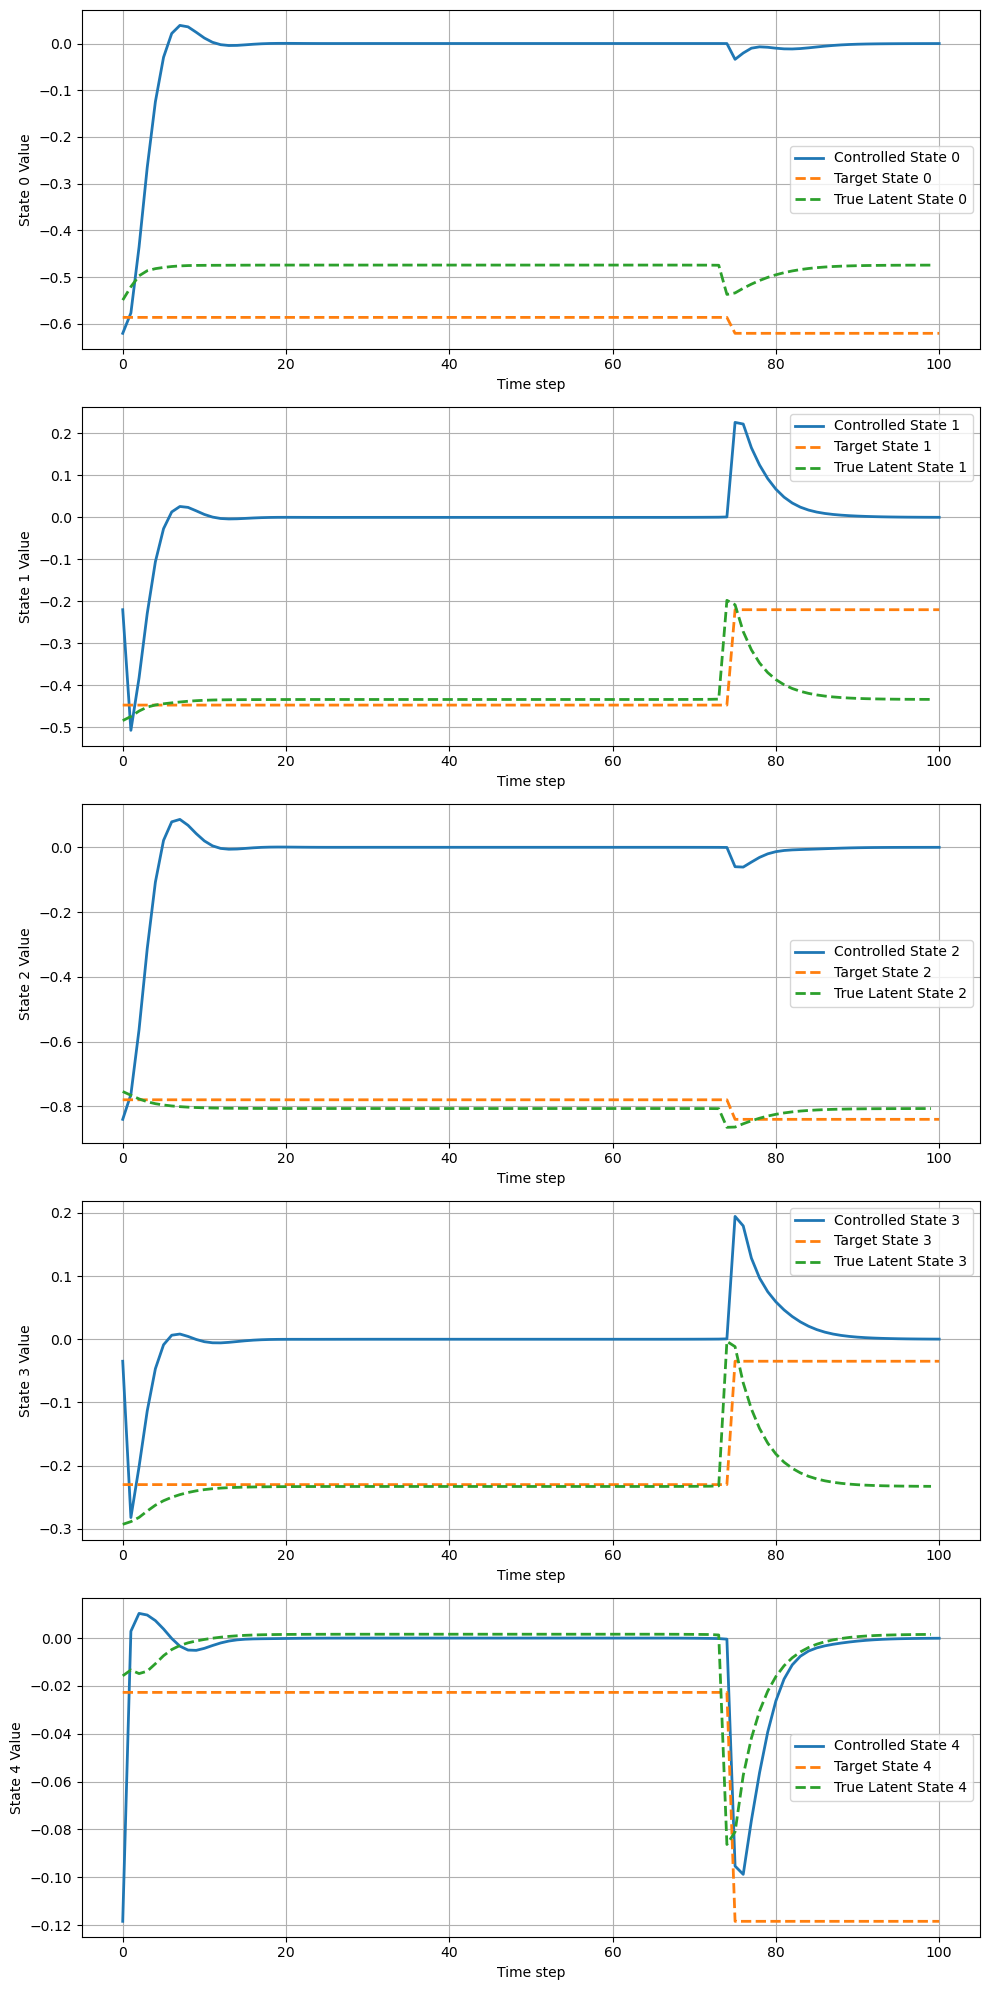

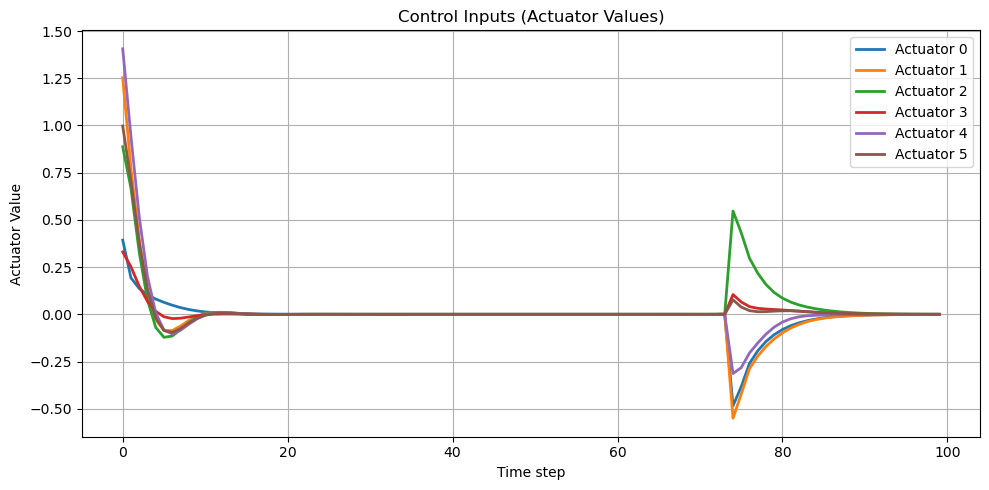

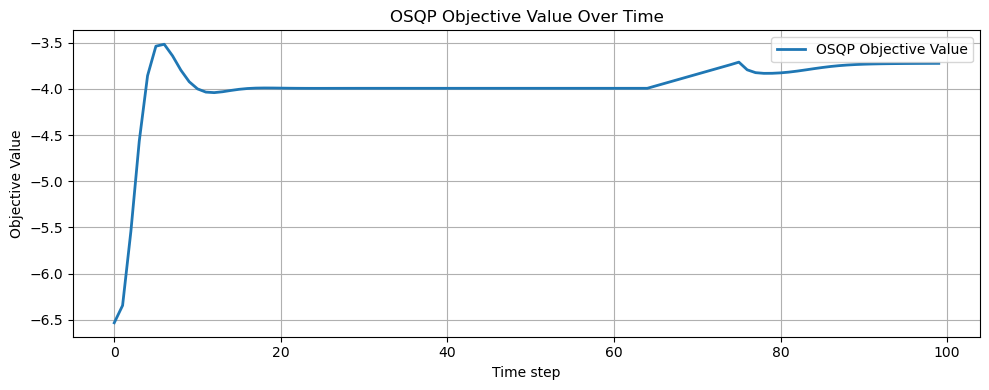

In [46]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the output dictionary from the pickle file.
save_path = 'control_pickles/control_results.pkl'
with open(save_path, 'rb') as f:
    output_dict = pickle.load(f)

# Extract data.
controlled_latent_traj = output_dict['controlled_latent_traj']  # shape: (T, nz)
target_latent_traj     = output_dict['target_latent_traj']      # shape: (T, nz)
actuator_values   = output_dict['actuator_values']    # shape: (nsim, nu)
objective_vals    = output_dict.get('objective_vals', None)
true_latent_traj  = output_dict['true_latent_traj']    # shape: (T, nz)

# --- Plot Controlled vs Target States ---
T, nz = controlled_latent_traj.shape
plt.figure(figsize=(10, 4 * nz))
for i in range(nz):
    plt.subplot(nz, 1, i + 1)
    plt.plot(controlled_latent_traj[:, i], label=f'Controlled State {i}', linewidth=2)
    plt.plot(target_latent_traj[:, i], '--', label=f'Target State {i}', linewidth=2)
    plt.plot(true_latent_traj[:, i], '--', label=f'True Latent State {i}', linewidth=2)
    plt.xlabel('Time step')
    plt.ylabel(f'State {i} Value')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Actuator Values ---
nsim, nu = actuator_values.shape
plt.figure(figsize=(10, 5))
for j in range(nu):
    plt.plot(actuator_values[:, j], label=f'Actuator {j}', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Actuator Value')
plt.legend()
plt.grid(True)
plt.title('Control Inputs (Actuator Values)')
plt.tight_layout()
plt.show()

# --- Optionally, Plot Objective Values ---
if objective_vals is not None:
    plt.figure(figsize=(10, 4))
    plt.plot(objective_vals, label='OSQP Objective Value', linewidth=2)
    plt.xlabel('Time step')
    plt.ylabel('Objective Value')
    plt.legend()
    plt.grid(True)
    plt.title('OSQP Objective Value Over Time')
    plt.tight_layout()
    plt.show()


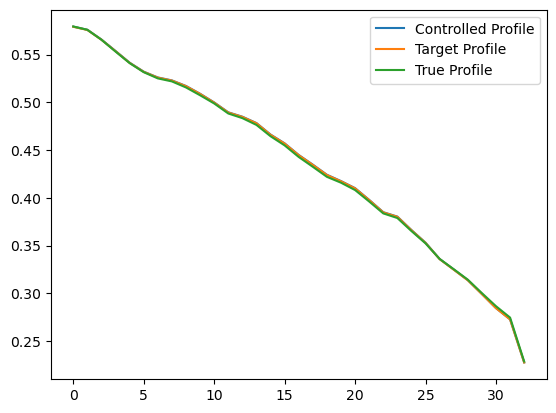

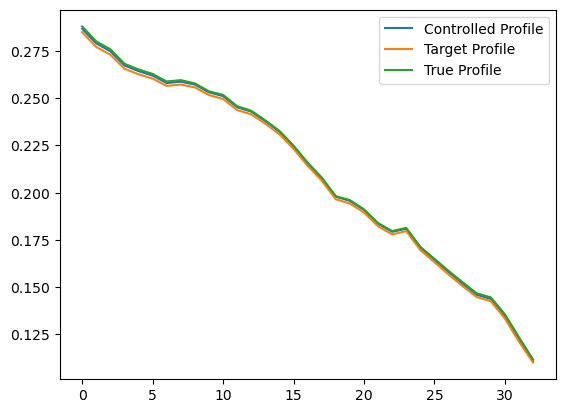

In [43]:
plt.plot(output_dict['controlled_traj'][50, :], label='Controlled Profile')
plt.plot(output_dict['target_traj'][50, :], label='Target Profile')
plt.plot(output_dict['true_traj'][50, :], label='True Profile')
plt.legend()
plt.show()
plt.plot(output_dict['controlled_traj'][99, :], label='Controlled Profile')
plt.plot(output_dict['target_traj'][99, :], label='Target Profile')
plt.plot(output_dict['true_traj'][99, :], label='True Profile')
plt.legend()

In [3]:
plt.rcParams.update({
    'font.size': 14,        # Global font size
    'axes.titlesize': 16,   # Font size of the axes title
    'axes.labelsize': 14,   # Font size of the x and y labels
    'xtick.labelsize': 12,  # Font size of the x tick labels
    'ytick.labelsize': 12,  # Font size of the y tick labels
    'legend.fontsize': 12,  # Font size of the legend
    'figure.titlesize': 16  # Font size of the figure title
})

In [6]:
lstm_model_name = 'HiroLRAN_v18'
#lstm_model_name = 'HiroLRAN_betan6'
linear_model_name = 'HiroLRAN_v18'
config_filename = f'/projects/EKOLEMEN/profile_predictor/joe_hiro_models/{lstm_model_name}config'
config=configparser.ConfigParser()
config.read(config_filename)
output_filename_base=config['model']['output_filename_base']
profiles=config['inputs']['profiles'].split()
actuators=config['inputs']['actuators'].split()
parameters=config['inputs'].get('parameters','').split()
calculations=config['inputs'].get('calculations','').split()
config_filename = f'/projects/EKOLEMEN/profile_predictor/joe_hiro_models/{linear_model_name}config'
config_linear=configparser.ConfigParser()
config_linear.read(config_filename)
controller_actuators = config_linear['inputs']['actuators'].split()
controller_profiles = config_linear['inputs']['profiles'].split()
controller_parameters = config_linear['inputs']['parameters'].split()
latent_dim = int(config_linear['HiroLRAN']['latent_dim'])
data_filename = config['preprocess']['preprocessed_data_filenamebase'] + 'val.pkl'

dict_keys(['real', 'controlled', 'time', 'osqp', 'true_latent_trajectory', 'true_z'])
(1, 1, 147, 33)
(1, 6, 147)
(1, 1, 147, 33)
(1, 6, 147)
(100, 1, 1, 3)
(1, 146, 3)


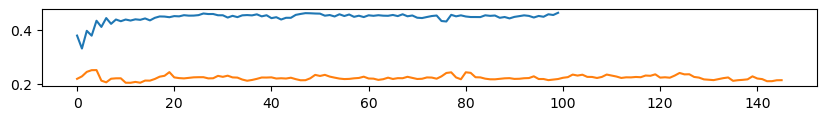

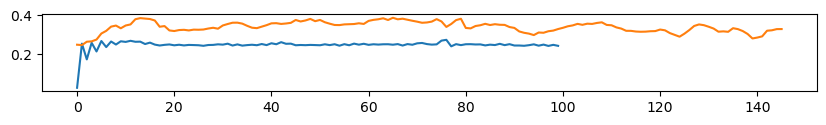

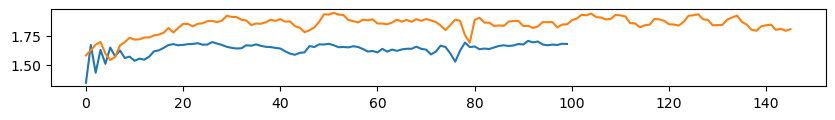

In [7]:

shot_index = 500
version = 0
# with open(f'control_pickles/{lstm_model_name}{linear_model_name}{shot_index}_integral_{version}.pkl', 'rb') as f:
#     control_model = pickle.load(f)
with open(f'control_pickles/{lstm_model_name}{linear_model_name}{shot_index}_integral_{version}.pkl', 'rb') as f:
    control_model = pickle.load(f)
print(control_model.keys())
print(control_model['real']['profiles'].shape)
print(control_model['real']['actuators'].shape)
print(control_model['controlled']['profiles'].shape)
print(control_model['controlled']['actuators'].shape)
print(control_model['true_latent_trajectory'].shape)
print(control_model['true_z'].shape)

for i in range(len(control_model['true_latent_trajectory'][0, 0, 0, :])):
    plt.figure(figsize=(10, 1))
    plt.plot(control_model['true_latent_trajectory'][:, 0, 0, i])
    plt.plot(control_model['true_z'][0, :, i])
    plt.show()

dict_keys(['real', 'controlled', 'time', 'osqp', 'true_latent_trajectory', 'true_z'])
(1, 1, 147, 33)
(1, 6, 147)
(1, 1, 147, 33)
(1, 6, 147)
(100, 1, 1, 3)
(1, 146, 3)


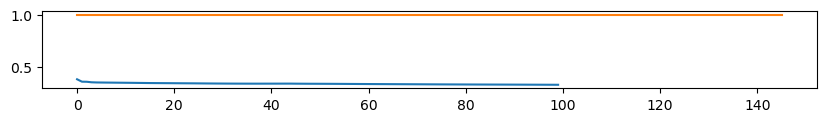

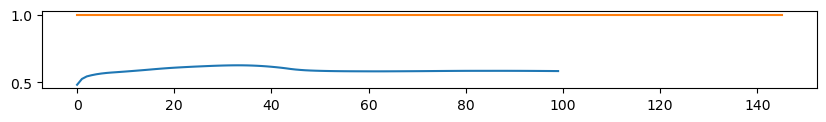

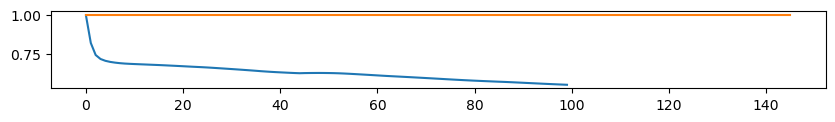

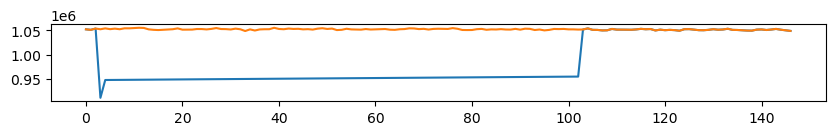

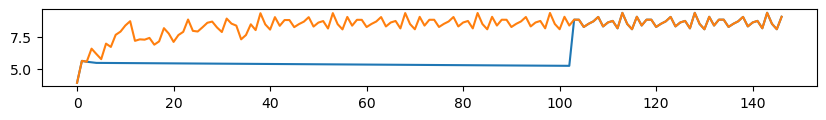

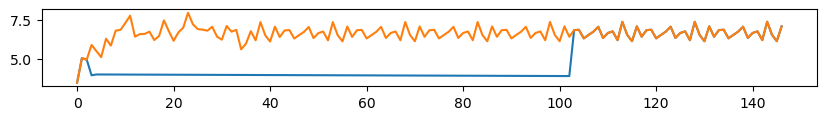

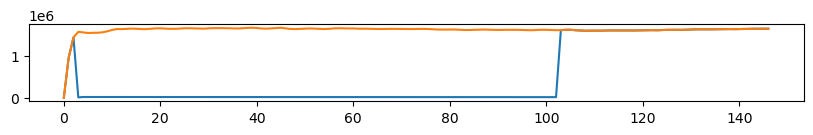

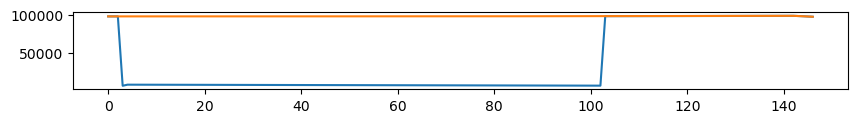

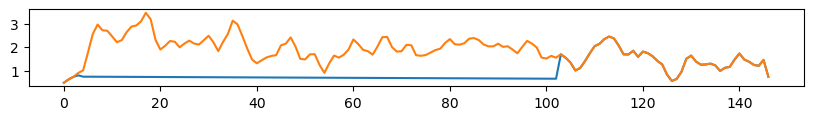

In [11]:
shot_index = 500
version = 1
# with open(f'control_pickles/{lstm_model_name}{linear_model_name}{shot_index}_integral_{version}.pkl', 'rb') as f:
#     control_model = pickle.load(f)
with open(f'control_pickles/{lstm_model_name}{linear_model_name}{shot_index}_integral_{version}.pkl', 'rb') as f:
    control_model = pickle.load(f)
print(control_model.keys())
print(control_model['real']['profiles'].shape)
print(control_model['real']['actuators'].shape)
print(control_model['controlled']['profiles'].shape)
print(control_model['controlled']['actuators'].shape)
print(control_model['true_latent_trajectory'].shape)
print(control_model['true_z'].shape)

for i in range(len(control_model['true_latent_trajectory'][0, 0, 0, :])):
    plt.figure(figsize=(10, 1))
    plt.plot(control_model['true_latent_trajectory'][:, 0, 0, i])
    plt.plot(control_model['true_z'][0, :, i])
    plt.show()
for i in range(len(control_model['controlled']['actuators'][0,:,0])):
    plt.figure(figsize=(10, 1))
    plt.plot(control_model['controlled']['actuators'][0, i, :])
    plt.plot(control_model['real']['actuators'][0, i, :])
    plt.ylabel('')
    plt.show()

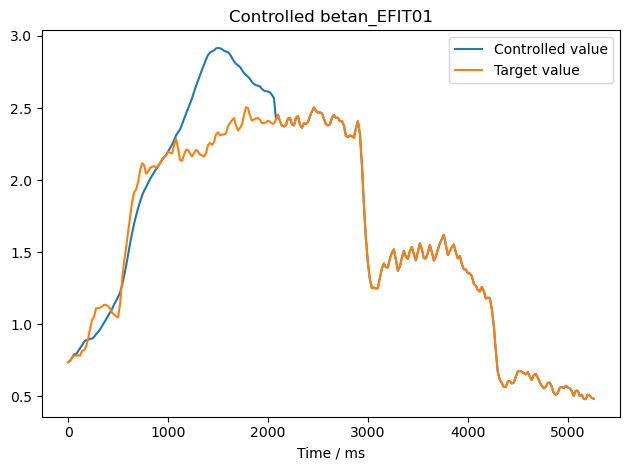

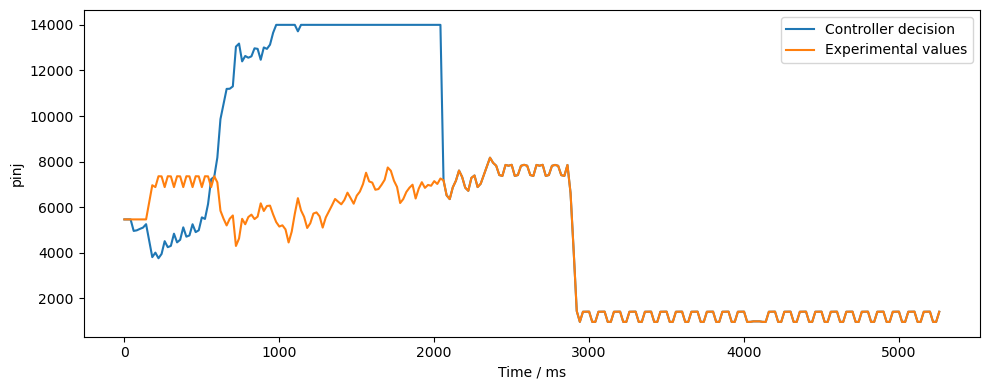

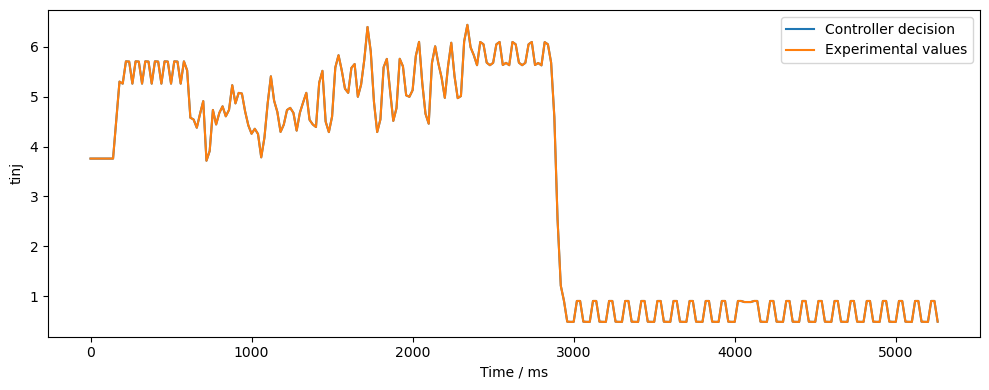

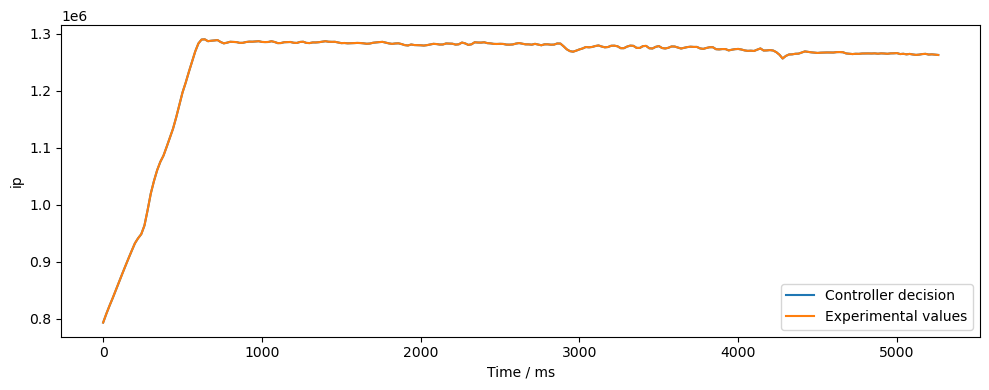

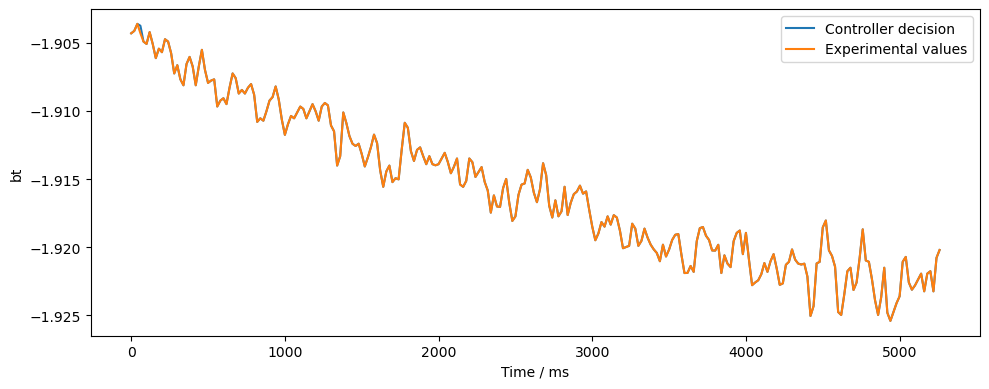

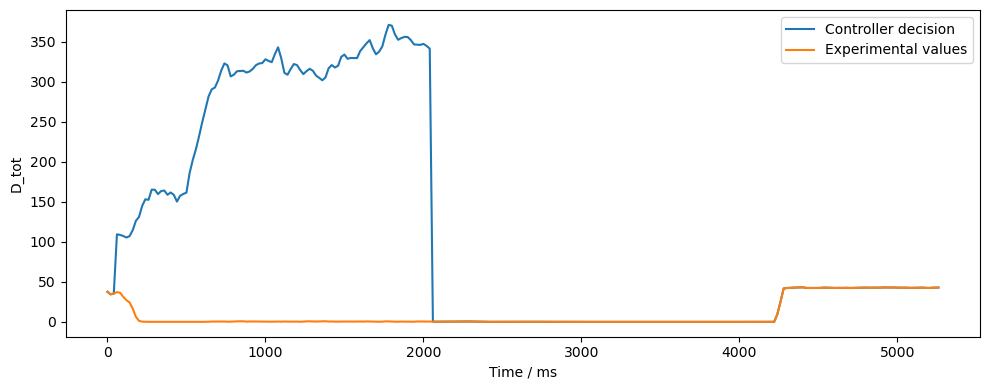

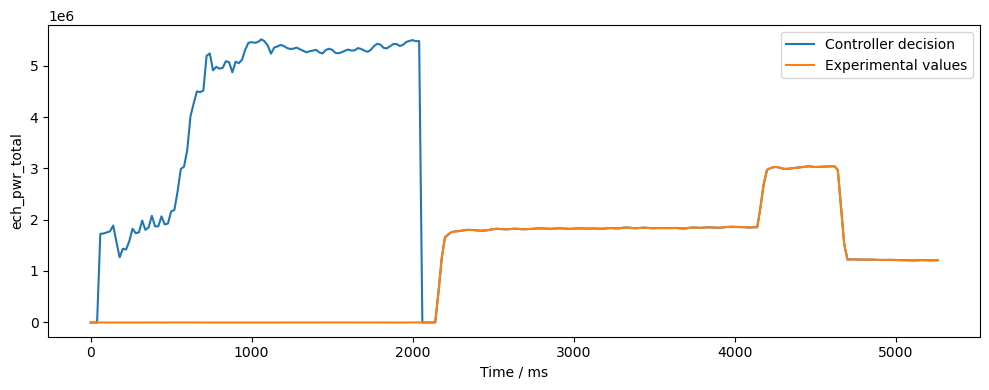

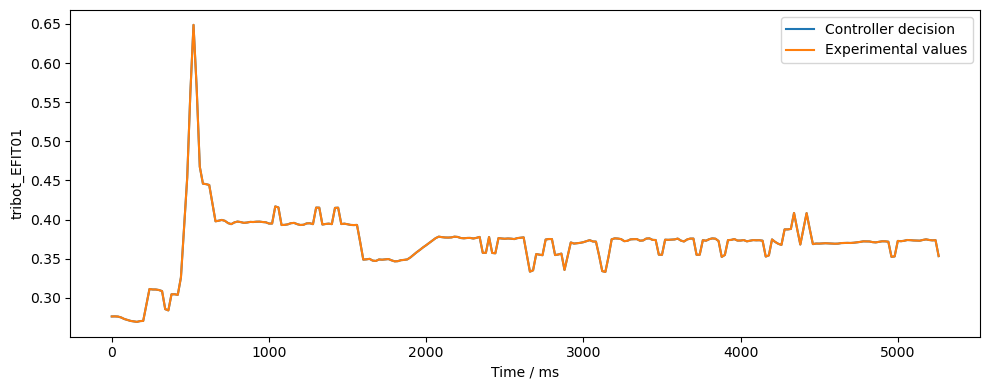

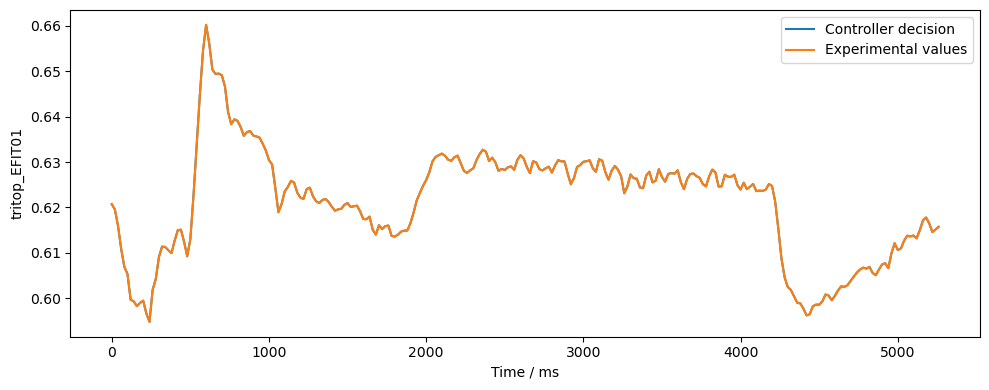

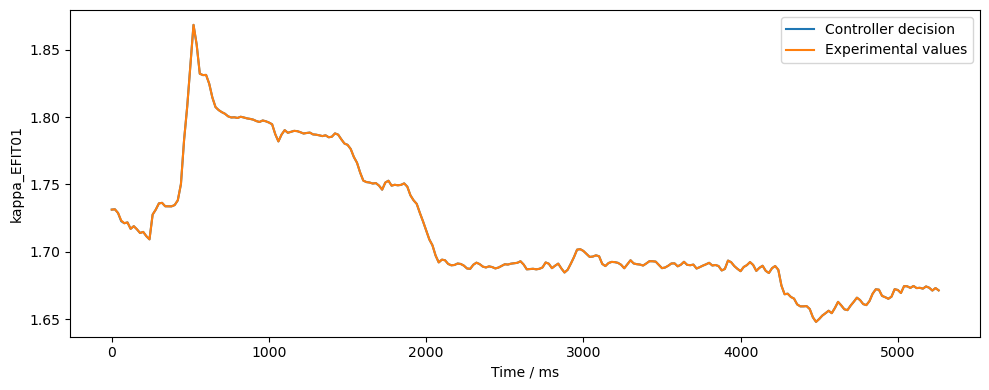

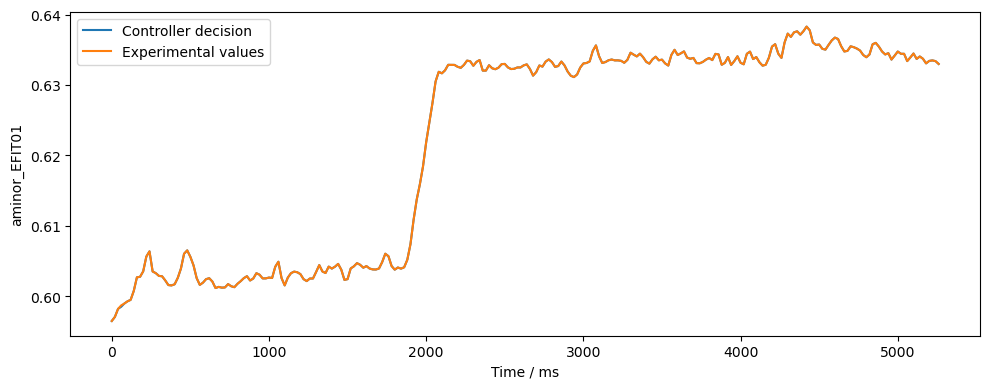

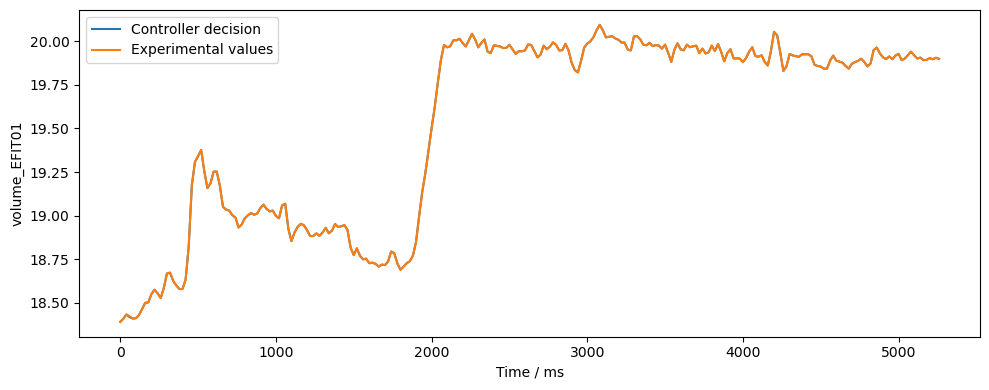

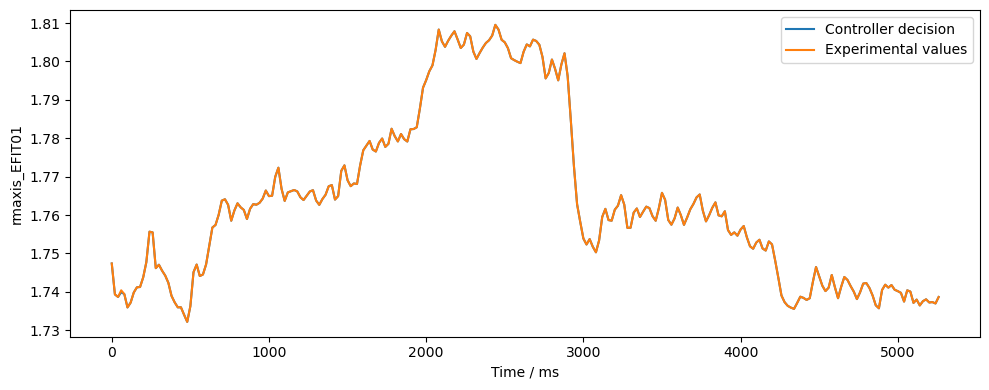

"plt.plot(np.arange(33)/33, control_model['controlled'][profile][0, 100, :], label='Controlled profile at 2s')\nplt.plot(np.arange(33)/33, control_model['real'][profile][103, :], label='Target profile at 2s')\n#plt.title(f'Controlled {profile}')\n#plt.ylabel(f'{profile}')\nplt.ylabel(r'$T_{e0}$')\nplt.xlabel(r'$\rho$')\nplt.legend()\nplt.xlim(0, 1)\nplt.tight_layout()\nplt.savefig('control_te_profile.svg')\nplt.show()"

In [92]:
#controller_actuators = ['pinj']
times = control_model['time']

for i, profile in enumerate(controller_profiles):
    plt.figure(figsize=(10, 4))
    plt.plot(times, control_model['controlled']['profiles'][0, i, :, 0], label='Controlled value')
    plt.plot(times, control_model['real']['profiles'][0, i, :, 0], label='Target value')
    #plt.title(f'Controlled {profile}')
    plt.ylabel(f'{profile}')
    #plt.title(r'Controlling $T_e$ using $P_{NBI}$ for shot 193775')
    #plt.ylabel(r'$T_{e0}$')
    plt.legend()
    plt.tight_layout()
    #plt.savefig('control_te.svg')
    plt.show()
for i, parameter in enumerate(controller_parameters):
    plt.plot(times, control_model['controlled']['parameters'][0, i, :], label='Controlled value')
    plt.plot(times, control_model['real']['parameters'][0, i, :], label='Target value')
    plt.title(f'Controlled {parameter}')
    plt.xlabel('Time / ms')
    plt.legend()
    plt.tight_layout()
    plt.show()
for i, actuator in enumerate(controller_actuators):
    plt.figure(figsize=(10, 4))
    plt.plot(times, control_model['controlled']['actuators'][0, i, :], label='Controller decision')
    plt.plot(times, control_model['real']['actuators'][0, i, :], label='Experimental values')
    #plt.title(f'Controlled {actuator}')
    #plt.ylabel('NBI power / MW')
    plt.ylabel(f'{actuator}')
    plt.xlabel('Time / ms')
    plt.legend()
    #plt.xlim(0, 4000)
    plt.tight_layout()
    plt.show()

'''plt.plot(np.arange(33)/33, control_model['controlled'][profile][0, 100, :], label='Controlled profile at 2s')
plt.plot(np.arange(33)/33, control_model['real'][profile][103, :], label='Target profile at 2s')
#plt.title(f'Controlled {profile}')
#plt.ylabel(f'{profile}')
plt.ylabel(r'$T_{e0}$')
plt.xlabel(r'$\rho$')
plt.legend()
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('control_te_profile.svg')
plt.show()'''

[0.99692374, 2.7765884, 0.6893911, 3.8168437, 1.7216603, 4.1709704, 0.85777515, 1.8323077, 2.6287522, 2.0762022, 0.9852279, 1.1393634, 0.6617722, 3.5712812, 1.291104, 2.7270064, 3.4414372, 3.6260333, 0.00021461915, 5.682437, 3.184975, 3.5879767, 3.1983008, 5.0290513, 1.5780728, 1.3710977, 1.6308119, 1.3260424, 1.3289186, 1.5346293, 4.920352, 2.7163997, 4.7152767, 1.3983262, 2.500244, 1.454278, 4.958758, 2.0236661, 3.147731, 2.2306523]


Text(0.5, 1.0, 'Timeseries of 40 latent space variables')

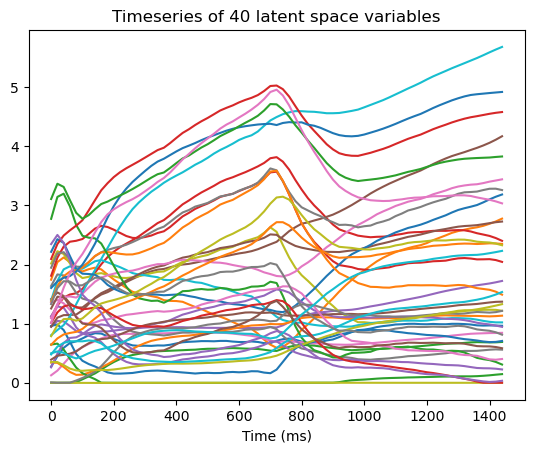

In [9]:
latent_space = np.array(control_model['latent'])
latent_size = []
for i in range(len(latent_space[0,0,0])):
    plt.plot(np.arange(0, len(latent_space))*20, latent_space[:,0,0,i])
    #latent_size.append(1/np.abs(max(latent_space[:,0,0,i])))
    latent_size.append(np.abs(max(latent_space[:,0,0,i])))
    plt.xlabel('Time (ms)')
print(latent_size)
plt.title('Timeseries of 40 latent space variables')

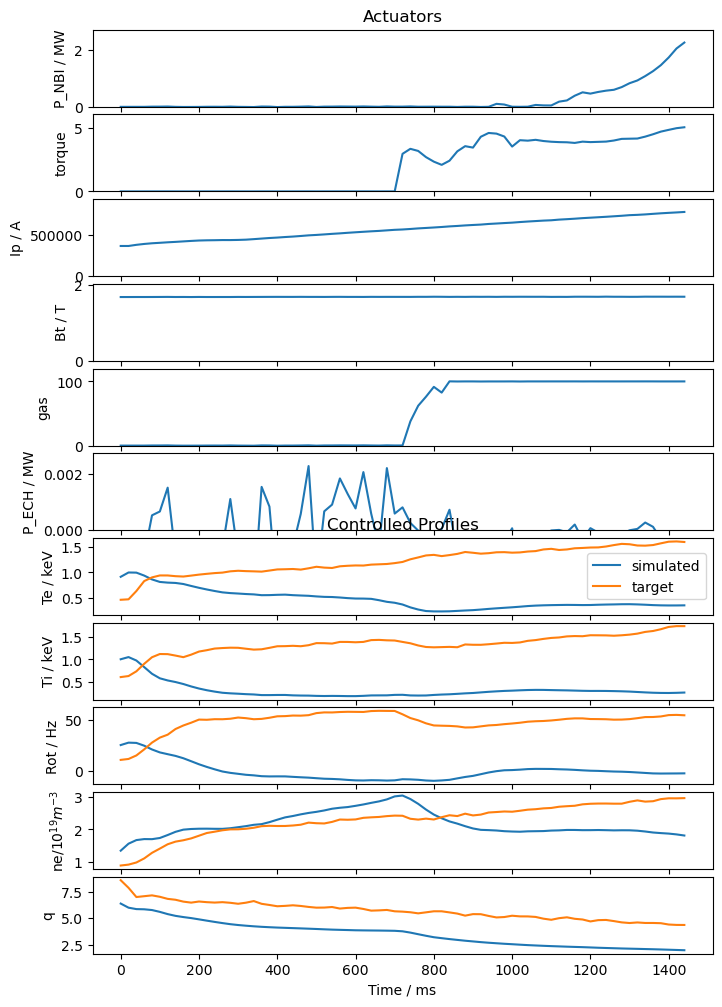

In [10]:
fig, axes = plt.subplots(nrows=len(control_model['controlled'].keys())-6, ncols=1, figsize=(8, 12), sharex=True)
actuator_label = ['P_NBI / MW', 'torque', 'Ip / A','Bt / T','gas', 'P_ECH / MW', 'tribot', 'tritop', 'kappa', 'a', 'volume', 'R']
actuator_label = ['P_NBI / MW', 'torque', 'Ip / A','Bt / T','gas', 'P_ECH / MW']
profile_labels = ['Te / keV', 'Ti / keV', 'Rot / Hz', r'ne/$10^{19}m^{-3}$', 'q']
#actuator_label = controller_actuators
#profile_labels = controller_profiles
time = np.arange(len(control_model['controlled'][actuators[0]][:,0]))*20

for i, ax in enumerate(axes):
    if i < len(actuator_label):
        if actuator_label[i] == 'P_NBI / MW':
            ax.plot(time, control_model['controlled'][controller_actuators[i]][:,0]/1000, label='controlled')
            #ax.plot(time, control_model['real'][controller_actuators[i]][:-3,0]/1000, label='experimental')
            ax.set_ylabel(f'{actuator_label[i]}')
            ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
            ax.yaxis.set_label_position('left')
            ax.set_ylim(0, np.max(control_model['controlled'][controller_actuators[i]][:,0]/1000)*1.2)
        elif actuator_label[i] == 'P_ECH / MW':
            ax.plot(time, control_model['controlled'][controller_actuators[i]][:,0]/1000000, label='controlled')
            #ax.plot(time, control_model['real'][controller_actuators[i]][:-3,0]/1000000, label='experimental')
            ax.set_ylabel(f'{actuator_label[i]}')
            ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
            ax.yaxis.set_label_position('left')
            ax.set_ylim(0, np.max(control_model['controlled'][controller_actuators[i]][:,0]/1000000)*1.2)
        else:
            ax.plot(time, control_model['controlled'][controller_actuators[i]][:,0], label='controlled')
            #ax.plot(time, control_model['real'][controller_actuators[i]][:-3,0], label='experimental')
            ax.set_ylabel(f'{actuator_label[i]}')
            ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
            ax.yaxis.set_label_position('left')
            ax.set_ylim(0, np.max(control_model['controlled'][controller_actuators[i]][:,0])*1.2)
    elif i < len(actuator_label) + len(controller_parameters):
        ax.plot(time, control_model['controlled'][controller_parameters[i-len(actuator_label)]])
        ax.plot(time, control_model['real'][controller_parameters[i-len(actuator_label)]][:-3])
        ax.set_ylabel(f'{actuator_label[i-len(actuator_label)]}')
        ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
        ax.yaxis.set_label_position('left')
    else:
        simulated_mean = np.mean(control_model['controlled'][controller_profiles[i - len(actuator_label) - len(controller_parameters)]][:, :], axis=1)
        real_mean = np.mean(control_model['real'][controller_profiles[i - len(actuator_label) - len(controller_parameters)]][:-3, :], axis=1)
        ax.plot(time, simulated_mean, label='simulated')
        ax.plot(time, real_mean, label='target')
        ax.set_ylabel(f'{profile_labels[i-len(actuator_label)-len(controller_parameters)]}')
        ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
        ax.yaxis.set_label_position('left')
        #ax.set_ylim(0, np.max(control_model['controlled'][controller_profiles[i - len(controller_actuators) - len(controller_parameters)]])*1.2)

# Set the x-axis label for the bottom subplot
axes[-1].set_xlabel('Time / ms')
#axes[0].legend()
axes[len(actuator_label)].legend()
axes[0].set_title('Actuators')
axes[len(actuator_label)].set_title('Controlled Profiles')
plt.subplots_adjust(hspace=0.1)
plt.savefig(f'control{lstm_model_name}{linear_model_name}{index}.png')
# Display the plot
plt.show()

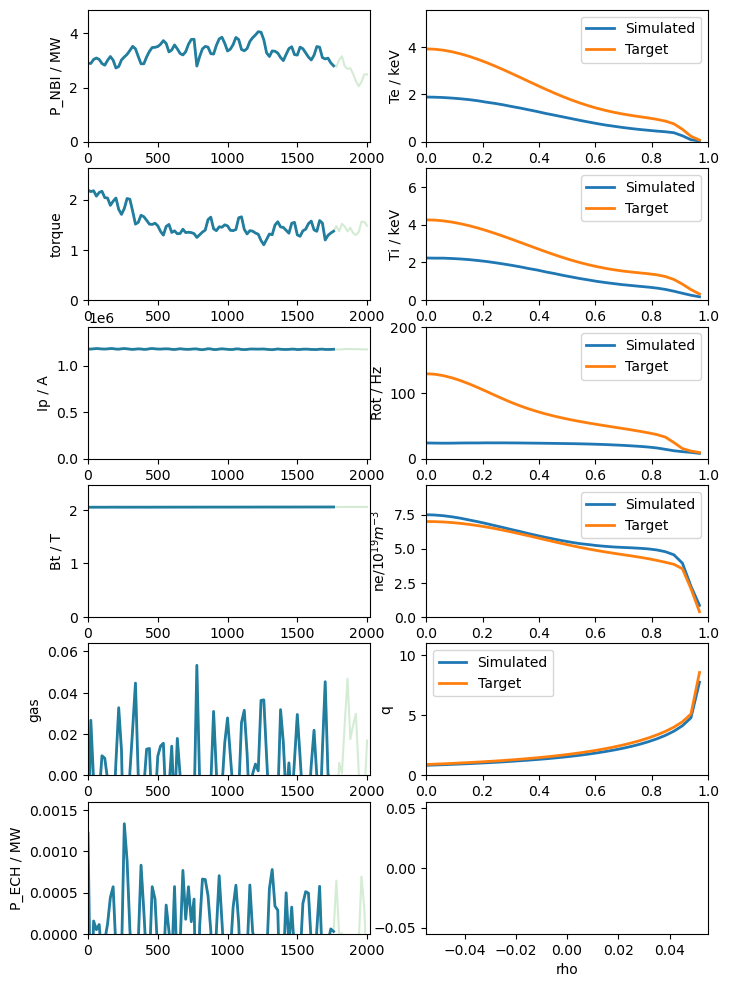

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

rhos = np.arange(33)/33
profile_labels = ['Te / keV', 'Ti / keV', 'Rot / Hz', r'ne/$10^{19}m^{-3}$', 'q']
actuator_label = ['P_NBI / MW', 'torque', 'Ip / A','Bt / T','gas', 'P_ECH / MW']
controller_actuators = controller_actuators[:6]
actuator_label = actuator_label[:6]
timetrace = control_model['controlled'][controller_actuators[0]][:,0]*1000

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 12))
#axes = axes.flatten()
axes = np.concatenate([axes[:,0], axes[:,1]], axis=0)
# Initialize line objects for each subplot
predictions = [ax.plot([], [], lw=2, label='Simulated')[0] for ax in axes]
targets = [ax.plot([], [], lw=2, label='Target')[0] for ax in axes]

# Set subplot limits and labels
for i, ax in enumerate(axes[:-1]):
    if i < len(controller_actuators):
        if actuator_label[i] == 'P_NBI / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(control_model['controlled'][controller_actuators[i]][:,0])*1.2/1000)
            ax.set_ylabel(actuator_label[i])
            ax.plot(np.arange(len(timetrace[:]))*20, control_model['controlled'][controller_actuators[i]][:,0][:]/1000, alpha=0.2)
        elif actuator_label[i] == 'P_ECH / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(control_model['controlled'][controller_actuators[i]][:,0])*1.2/1000000)
            ax.set_ylabel(actuator_label[i])
            ax.plot(np.arange(len(timetrace[:]))*20, control_model['controlled'][controller_actuators[i]][:,0][:]/1000000, alpha=0.2)
        else:
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(control_model['controlled'][controller_actuators[i]][:,0])*1.2)
            ax.set_ylabel(actuator_label[i])
            ax.plot(np.arange(len(timetrace[:]))*20, control_model['controlled'][controller_actuators[i]][:,0][:], alpha=0.2)
    else:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, np.max(control_model['real'][profiles[i-len(controller_actuators)]][:-3, :])*1.2)
        ax.set_ylabel(profile_labels[i-len(controller_actuators)])
        ax.legend()
axes[len(controller_actuators)].set_xlabel('Time / ms')
axes[-1].set_xlabel('rho')

#title_text = axes[0].annotate('', xy=(0.5, 1.05), xycoords='axes fraction', fontsize=10, ha='center', va='bottom')

def animate(time):
    for i in range(len(axes)-1):
        if i < len(controller_actuators):
            if actuator_label[i] == 'P_NBI / MW':
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['controlled'][controller_actuators[i]][:time,0]/1000)
                #targets[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['real'][controller_actuators[i]][:-3,0]/1000)
            elif actuator_label[i] == 'P_ECH / MW':
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['controlled'][controller_actuators[i]][:time,0]/1000000)
                #targets[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['real'][controller_actuators[i]][:-3,0]/1000000)
            else:
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['controlled'][controller_actuators[i]][:time,0])
            #targets[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['controlled'][controller_actuators[i]][:time,0][:])
        else:
            predictions[i].set_data(rhos, control_model['controlled'][controller_profiles[i-len(controller_actuators)]][time])
            targets[i].set_data(rhos, control_model['real'][controller_profiles[i-len(controller_actuators)]][:-3][time])
    #predictions[5].set_data(np.arange(len(timetrace[:time])), timetrace[:time])

    #title_text.set_text(f'Profiles at time {time*20}ms')
    return predictions + targets

# Create the animation object
ani = animation.FuncAnimation(fig, animate, frames=90, interval=150, blit=True)
ani.save(f'{lstm_model_name}{linear_model_name}{index}.mp4', writer='ffmpeg')
# Display the animation as an HTML5 video
HTML(ani.to_html5_video())